In [ ]:
import os
import torch
import torchaudio
from datasets import Dataset, Audio
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

In [ ]:
DATA_DIR = "drive/MyDrive/Ravdess Dataset"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
emotion_map = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}
label2id = {v: i for i, v in enumerate(emotion_map.values())}
id2label = {i: v for v, i in label2id.items()}


In [ ]:
def load_metadata_from_nested_dirs():
    data = []
    for actor_folder in os.listdir(DATA_DIR):
        actor_path = os.path.join(DATA_DIR, actor_folder)
        if not os.path.isdir(actor_path):
            continue
        for fname in os.listdir(actor_path):
            if not fname.endswith(".wav"):
                continue
            fpath = os.path.join(actor_path, fname)
            parts = fname.split("-")
            if len(parts) < 3:
                continue
            emotion_code = parts[2]
            if emotion_code not in emotion_map:
                continue
            emotion_label = emotion_map[emotion_code]
            data.append({"path": fpath, "label": label2id[emotion_label]})
    return Dataset.from_list(data)


In [ ]:
dataset = load_metadata_from_nested_dirs()
dataset = dataset.cast_column("path", Audio(sampling_rate=16000))


In [ ]:
model_name = "facebook/wav2vec2-base"
processor = Wav2Vec2Processor.from_pretrained(model_name)
model = Wav2Vec2ForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label2id),
    label2id=label2id,
    id2label=id2label
).to(device)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def preprocess_function(batch):
    audio = batch["path"]
    inputs = processor(audio["array"], sampling_rate=audio["sampling_rate"], return_tensors="pt", padding=True)
    batch["input_values"] = inputs.input_values[0]
    batch["labels"] = batch["label"]
    return batch

dataset = dataset.map(preprocess_function, remove_columns=["path"])


Map:   0%|          | 0/1471 [00:00<?, ? examples/s]

In [ ]:
dataset = dataset.train_test_split(test_size=0.2)
train_dataset = dataset["train"]
eval_dataset = dataset["test"]

In [ ]:
def data_collator(features):
    input_values = [f["input_values"] for f in features]
    labels = [f["labels"] for f in features]

    batch = processor.pad(
        {"input_values": input_values},
        padding=True,
        return_tensors="pt"
    )
    batch["labels"] = torch.tensor(labels, dtype=torch.long)
    return batch

In [ ]:
def compute_metrics(pred):
    preds = pred.predictions.argmax(-1)
    labels = pred.label_ids
    return {
        "accuracy": accuracy_score(labels, preds),
        "report": classification_report(labels, preds, output_dict=True)
    }

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    report_to="none"
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor.feature_extractor,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

<ipython-input-16-458b4324d277>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Report
1,1.832800,1.663087,0.481356,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 19.0}, '1': {'precision': 0.3697478991596639, 'recall': 1.0, 'f1-score': 0.5398773006134969, 'support': 44.0}, '2': {'precision': 0.45, 'recall': 0.23076923076923078, 'f1-score': 0.3050847457627119, 'support': 39.0}, '3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 40.0}, '4': {'precision': 0.7727272727272727, 'recall': 0.7906976744186046, 'f1-score': 0.7816091954022989, 'support': 43.0}, '5': {'precision': 0.45652173913043476, 'recall': 0.6363636363636364, 'f1-score': 0.5316455696202531, 'support': 33.0}, '6': {'precision': 0.6666666666666666, 'recall': 0.46153846153846156, 'f1-score': 0.5454545454545454, 'support': 39.0}, '7': {'precision': 0.5925925925925926, 'recall': 0.42105263157894735, 'f1-score': 0.49230769230769234, 'support': 38.0}, 'accuracy': 0.48135593220338985, 'macro avg': {'precision': 0.4135320212845788, 'recall': 0.4425527043336101, 'f1-score': 0.39949738114512484, 'support': 295.0}, 'weighted avg': {'precision': 0.44281327525464687, 'recall': 0.48135593220338985, 'f1-score': 0.42978584776924206, 'support': 295.0}}"
2,1.425100,1.239040,0.647458,"{'0': {'precision': 0.4, 'recall': 0.10526315789473684, 'f1-score': 0.16666666666666666, 'support': 19.0}, '1': {'precision': 0.582089552238806, 'recall': 0.8863636363636364, 'f1-score': 0.7027027027027027, 'support': 44.0}, '2': {'precision': 0.75, 'recall': 0.23076923076923078, 'f1-score': 0.35294117647058826, 'support': 39.0}, '3': {'precision': 0.5142857142857142, 'recall': 0.45, 'f1-score': 0.48, 'support': 40.0}, '4': {'precision': 0.6896551724137931, 'recall': 0.9302325581395349, 'f1-score': 0.7920792079207921, 'support': 43.0}, '5': {'precision': 0.5555555555555556, 'recall': 0.7575757575757576, 'f1-score': 0.6410256410256411, 'support': 33.0}, '6': {'precision': 0.8108108108108109, 'recall': 0.7692307692307693, 'f1-score': 0.7894736842105263, 'support': 39.0}, '7': {'precision': 0.7777777777777778, 'recall': 0.7368421052631579, 'f1-score': 0.7567567567567568, 'support': 38.0}, 'accuracy': 0.6474576271186441, 'macro avg': {'precision': 0.6350218228853072, 'recall': 0.608284651904603, 'f1-score': 0.5852057294692092, 'support': 295.0}, 'weighted avg': {'precision': 0.6515222094719989, 'recall': 0.6474576271186441, 'f1-score': 0.6163043186554102, 'support': 295.0}}"
3,0.995700,1.051712,0.725424,"{'0': {'precision': 0.4, 'recall': 0.7368421052631579, 'f1-score': 0.5185185185185185, 'support': 19.0}, '1': {'precision': 0.9411764705882353, 'recall': 0.36363636363636365, 'f1-score': 0.5245901639344263, 'support': 44.0}, '2': {'precision': 0.8148148148148148, 'recall': 0.5641025641025641, 'f1-score': 0.6666666666666666, 'support': 39.0}, '3': {'precision': 0.6, 'recall': 0.9, 'f1-score': 0.72, 'support': 40.0}, '4': {'precision': 0.8333333333333334, 'recall': 0.813953488372093, 'f1-score': 0.8235294117647058, 'support': 43.0}, '5': {'precision': 0.8333333333333334, 'recall': 0.7575757575757576, 'f1-score': 0.7936507936507936, 'support': 33.0}, '6': {'precision': 0.7346938775510204, 'recall': 0.9230769230769231, 'f1-score': 0.8181818181818182, 'support': 39.0}, '7': {'precision': 0.8571428571428571, 'recall': 0.7894736842105263, 'f1-score': 0.821917808219178, 'support': 38.0}, 'accuracy': 0.7254237288135593, 'macro avg': {'precision': 0.7518118358454493, 'recall': 0.7310826107796733, 'f1-score': 0.7108818976170135, 'support': 295.0}, 'weighted avg': {'precision': 0.7774486969929214, 'recall': 0.7254237288135593, 'f1-score': 0.7202645002804909, 'support': 295.0}}"
4,0.771600,0.788837,0.823729,"{'0': {'precision': 0.5833333333333334, 'recall': 0.3684210526315789, 'f1-score': 0.45161290322580644, 'support': 19.0}, '1': {'precision': 0.9714285714285714, 'recall': 0.7727272727272727, 'f1-score': 0.8607594936708861, 'support': 44.0}, '2': {'precision': 0.7380952380952381, 'recall': 0.7948717948717948, 'f1-scor

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=1470, training_loss=0.6739854765992587, metrics={'train_runtime': 1545.5314, 'train_samples_per_second': 7.609, 'train_steps_per_second': 0.951, 'total_flos': 4.526114162659914e+17, 'train_loss': 0.6739854765992587, 'epoch': 10.0})

In [ ]:
model.save_pretrained("./saved_model1")
processor.save_pretrained("./saved_model1")

[]

Classification Report:
              precision    recall  f1-score   support

     neutral       0.67      0.95      0.78        19
        calm       0.90      0.86      0.88        44
       happy       0.85      0.87      0.86        39
         sad       0.90      0.88      0.89        40
       angry       0.89      0.93      0.91        43
     fearful       1.00      0.91      0.95        33
     disgust       0.92      0.90      0.91        39
   surprised       0.91      0.82      0.86        38

    accuracy                           0.88       295
   macro avg       0.88      0.89      0.88       295
weighted avg       0.89      0.88      0.89       295



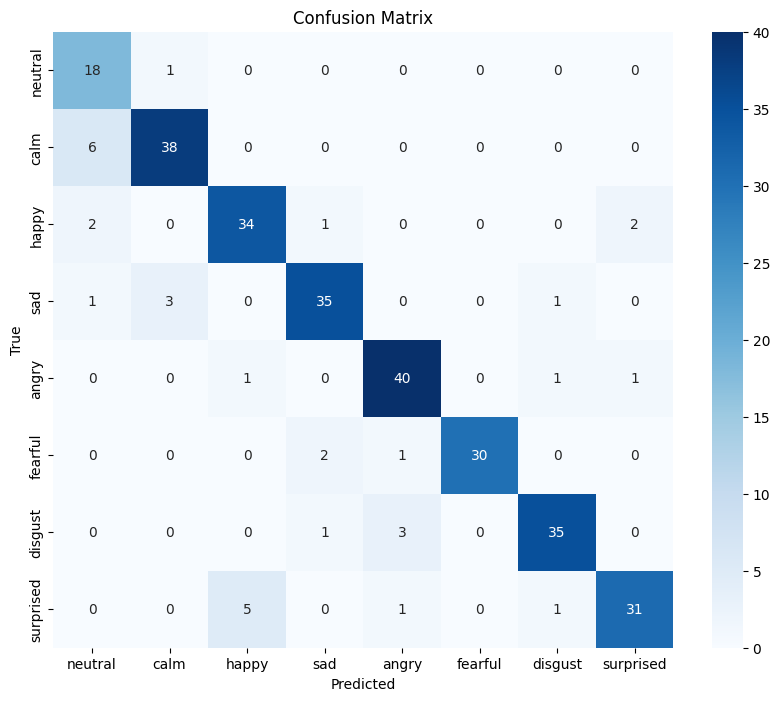

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = trainer.predict(eval_dataset)

y_true = predictions.label_ids
y_pred = predictions.predictions.argmax(-1)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=id2label.values()))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=id2label.values(), yticklabels=id2label.values())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


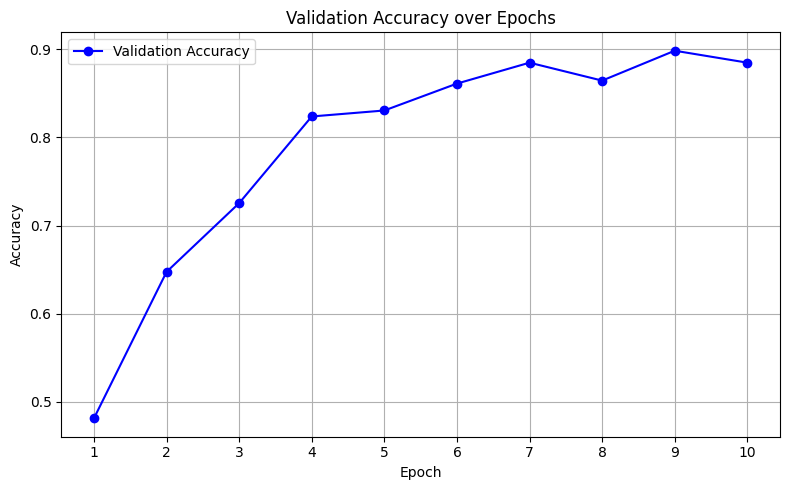

In [ ]:
import matplotlib.pyplot as plt

train_acc = []
eval_acc = []
epochs = []

for log in trainer.state.log_history:
    if "eval_accuracy" in log:
        eval_acc.append(log["eval_accuracy"])
        epochs.append(log["epoch"])
    if "loss" in log and "epoch" in log and "eval_accuracy" not in log:
        pass

plt.figure(figsize=(8, 5))
plt.plot(epochs, eval_acc, marker='o', label="Validation Accuracy", color='blue')
plt.title("Validation Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(epochs)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


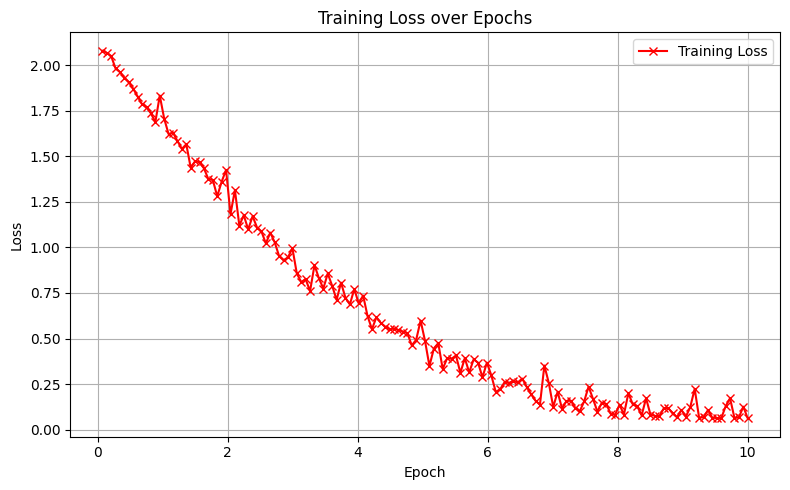

In [ ]:
train_loss = []
for log in trainer.state.log_history:
    if "loss" in log and "epoch" in log and "eval_accuracy" not in log:
        train_loss.append((log["epoch"], log["loss"]))

# Then plot it:
loss_epochs, loss_values = zip(*train_loss)
plt.figure(figsize=(8, 5))
plt.plot(loss_epochs, loss_values, marker='x', label="Training Loss", color='red')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import torch
import torchaudio
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2Processor
import numpy as np


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Wav2Vec2ForSequenceClassification.from_pretrained("/content/drive/MyDrive/ser-model").to(device)
processor = Wav2Vec2Processor.from_pretrained("/content/drive/MyDrive/ser-model")


In [ ]:
id2label = {
    0: "neutral",
    1: "calm",
    2: "happy",
    3: "sad",
    4: "angry",
    5: "fearful",
    6: "disgust",
    7: "surprised"
}


In [ ]:
def predict_emotion(audio_path):
    waveform, sample_rate = torchaudio.load(audio_path)

    if sample_rate != 16000:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
        waveform = resampler(waveform)

    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0).unsqueeze(0)

    inputs = processor(waveform.squeeze().numpy(), sampling_rate=16000, return_tensors="pt", padding=True)

    input_values = inputs.input_values.to(device)

    with torch.no_grad():
        logits = model(input_values).logits
        predicted_id = torch.argmax(logits, dim=-1).item()

    return id2label[predicted_id]


In [ ]:
file_path = "/content/1000_20250524004123-1748027483.133.wav"
predicted_emotion = predict_emotion(file_path)
print(f"Predicted Emotion: {predicted_emotion}")

Predicted Emotion: disgust
